## Imports needed

In [52]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
import time

## PCA on Olevitti dataset
### Dataset contains 40 people each having 10 images

In [2]:
oliv = datasets.fetch_olivetti_faces()

In [3]:
oliv.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [4]:
oliv['data'].shape

(400, 4096)

In [5]:
oliv['images'].shape # It means there are 400 images each having 64 by 64 size

(400, 64, 64)

### Now we plot 64 images out of 400 images

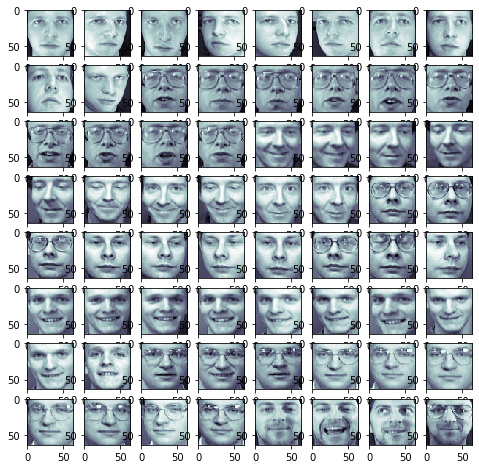

In [6]:
fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(oliv['images'][i],cmap=plt.cm.bone)
plt.show()

In [7]:
x = oliv.data
y = oliv.target

In [8]:
pca = PCA()
pca.fit(x)
pca.components_.shape

(400, 4096)

In [9]:
pca.explained_variance_.shape

(400,)

### Find optimal number of components

In [10]:
k=0
total=sum(pca.explained_variance_)
current = 0
while current/total < 0.95:
    current = current + pca.explained_variance_[k]
    k += 1
k

123

In [11]:
pca = PCA(n_components=k)
transformed_data = pca.fit_transform(x)
transformed_data.shape

(400, 123)

In [12]:
pca.components_.shape

(123, 4096)

### Reproduce images

In [13]:
x_approx = pca.inverse_transform(transformed_data)
x_approx.shape

(400, 4096)

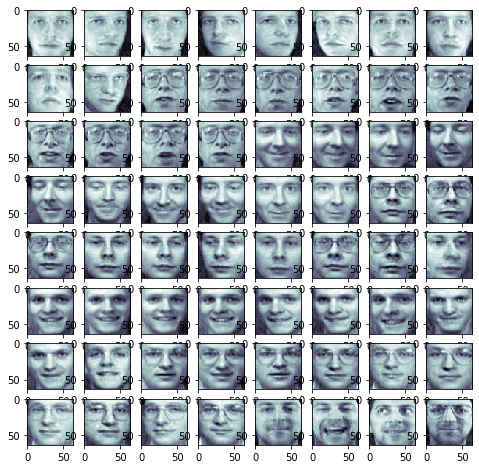

In [14]:
# Plot 64 out of these images
x_approx_images = x_approx.reshape((400, 64, 64))
fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(x_approx_images[i], cmap=plt.cm.bone)
plt.show()

### Eigen Faces

In [15]:
eigenv = pca.components_

In [16]:
eigenv.shape

(123, 4096)

In [17]:
eigenfaces = eigenv.reshape((123,64,64))

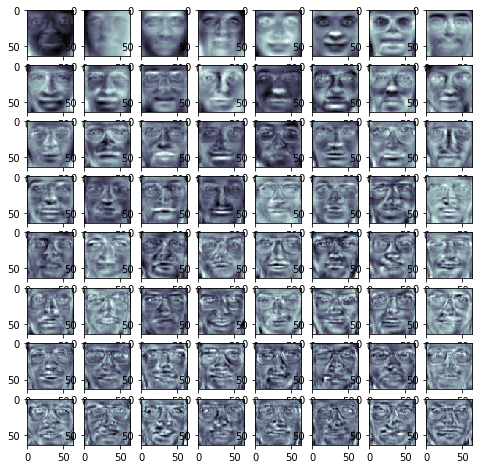

In [18]:
fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(eigenfaces[i], cmap=plt.cm.bone)
plt.show()

## Classification of LFW Images

In [20]:
lfw = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [21]:
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [22]:
lfw.data.shape

(1140, 1850)

In [23]:
lfw.images.shape

(1140, 50, 37)

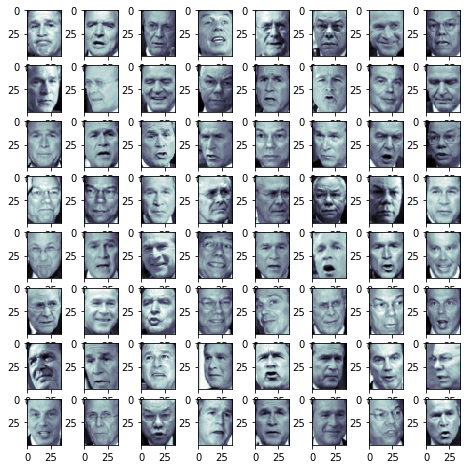

In [25]:
fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(lfw.images[i], cmap=plt.cm.bone)
plt.show()

In [27]:
x,y = lfw.data, lfw.target

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)

In [30]:
pca_oliv = PCA()
pca_oliv.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
k=0
total = 0
while total<0.99:
    total += pca_oliv.explained_variance_ratio_[k]
    k += 1
k

316

In [32]:
pca_lfw = PCA(n_components = k, whiten=True)

In [33]:
x_transformed = pca_lfw.fit_transform(x_train)

In [40]:
x_transformed.shape

(855, 316)

In [41]:
pca_lfw.components_.shape

(316, 1850)

### Get original data back

In [42]:
x_approx = pca_lfw.inverse_transform(x_transformed)

In [45]:
x_approx = x_approx.reshape((855, 50, 37))

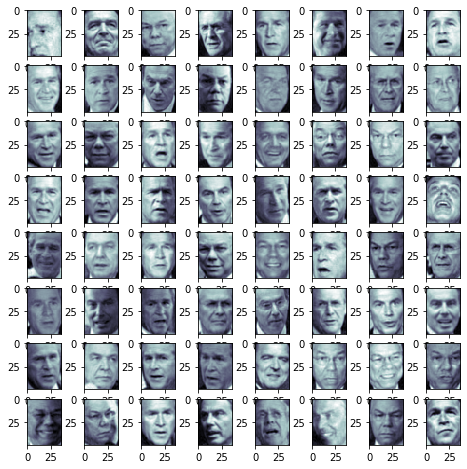

In [46]:
fig = plt.figure(figsize=(8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(x_approx[i], cmap=plt.cm.bone)
plt.show()

### Now we apply classification with PCA and without PCA

In [48]:
x_train_pca = x_transformed
x_test_pca = pca_lfw.transform(x_test)

### Without PCA

In [49]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(x_train, y_train)
print(time.time()-start)

c:\users\mehak\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6821150779724121


In [53]:
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62        61
           1       0.56      0.28      0.37        36
           2       0.64      0.89      0.74       122
           3       0.70      0.23      0.34        31
           4       0.57      0.23      0.33        35

    accuracy                           0.61       285
   macro avg       0.61      0.46      0.48       285
weighted avg       0.61      0.61      0.57       285



In [54]:
print(confusion_matrix(y_test, y_pred))

[[ 42   1  15   2   1]
 [  9  10  16   0   1]
 [  9   1 108   0   4]
 [  6   2  16   7   0]
 [  8   4  14   1   8]]


### With PCA

In [55]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(x_train_pca, y_train)
print(time.time()-start)

c:\users\mehak\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.2333381175994873


In [56]:
y_pred = rf.predict(x_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.43      0.43        61
           1       0.54      0.19      0.29        36
           2       0.50      0.80      0.61       122
           3       0.17      0.03      0.05        31
           4       0.42      0.14      0.21        35

    accuracy                           0.48       285
   macro avg       0.41      0.32      0.32       285
weighted avg       0.44      0.48      0.42       285



In [57]:
print(confusion_matrix(y_test, y_pred))

[[26  1 30  2  2]
 [ 6  7 23  0  0]
 [16  3 97  2  4]
 [ 8  1 20  1  1]
 [ 3  1 25  1  5]]


### Conclusion
- Using PCA speed increases but accuracy is very poor in this case. So we try different parameters or use grid search to find best parameters or try some different classifier like SVM